In [46]:
import pandas as pd
import numpy as np

import requests

from time import sleep 

import tqdm
import re 

from typing import Dict, List 

from random import randint

In [47]:
category_main_cb = 4 # 1=byty, 2=domy, 3=pozemky, 4=komerční, 5=ostatní
category_type_cb = 1 # 1=prodej, 2=nájem, 3=dražba
locality_region_id = 10 #10=Prague

category_main_cb_dict={1:"flat", 2:"domy", 3:"pozemky", 4:"komerční", 5:"ostatní"}
category_main_cb_dict=pd.DataFrame.from_dict(category_main_cb_dict, orient="index", columns=["category_main_cb"])
print(category_main_cb_dict)

category_type_cb_dict={1:"prodej", 2:"nájem", 3:"dražba"}
category_type_cb_dict=pd.DataFrame.from_dict(category_type_cb_dict, orient="index", columns=["category_type_cb"])
print(category_type_cb_dict)

  category_main_cb
1             flat
2             domy
3          pozemky
4         komerční
5          ostatní
  category_type_cb
1           prodej
2            nájem
3           dražba


In [48]:
collector={}
i=0
run=True

while run==True:
    base_url = 'https://www.sreality.cz/api/cs/v2/estates?category_main_cb={}&category_type_cb={}&locality_region_id={}&per_page60&page={}'.format(category_main_cb, category_type_cb, locality_region_id, i)

    r = requests.get(base_url)
    print("starting sleep")
    sleep(randint(1,3))

    if r.status_code==404:
        break
    elif r.status_code==200:
        r_dict=r.json()

        if len(r_dict["_embedded"]["estates"]) == 0:
            print(f"Page {i+1} is blank.")
            break

        collector[i]=r_dict
        
        print(f"Page {i+1} was scraped.")

        i=i+1
        j=0

    else:
        if  j==3:
            print(f"Code {r.status_code} was returned.")
            break
        else:
            j=j+1

starting sleep
Page 1 was scraped.
starting sleep
Page 2 was scraped.
starting sleep
Page 3 was scraped.
starting sleep
Page 4 was scraped.
starting sleep
Page 5 was scraped.
starting sleep
Page 6 was scraped.
starting sleep
Page 7 was scraped.
starting sleep
Page 8 was scraped.
starting sleep
Page 9 was scraped.
starting sleep
Page 10 was scraped.
starting sleep
Page 11 was scraped.
starting sleep
Page 12 was scraped.
starting sleep
Page 13 was scraped.
starting sleep
Page 14 was scraped.
starting sleep
Page 15 was scraped.
starting sleep
Page 16 was scraped.
starting sleep
Page 17 was scraped.
starting sleep
Page 18 was scraped.
starting sleep
Page 19 was scraped.
starting sleep
Page 20 was scraped.
starting sleep
Page 21 was scraped.
starting sleep
Page 22 was scraped.
starting sleep
Page 23 was scraped.
starting sleep
Page 24 was scraped.
starting sleep
Page 25 was scraped.
starting sleep
Page 26 was scraped.
starting sleep
Page 27 was scraped.
starting sleep
Page 28 is blank.


In [49]:
def get_gps_lat_lon(estate_raw: Dict):
    gps_ = estate_raw['gps']
    return gps_['lat'], gps_['lon']

# more robust implementation using regex - https://docs.python.org/3/library/re.html
def get_area_from_name(name: str):
    """(\d*) matches any decimal digits (repeated after each other"""
    name_ = name.split()
    return int(''.join(re.findall('(\d*)', ''.join(name_))))


In [50]:
collector[0];

In [88]:
collector[0]['_embedded']["estates"][0]

{'labelsReleased': [[], []],
 'has_panorama': 0,
 'labels': [],
 'is_auction': False,
 'labelsAll': [[''],
  ['playground',
   'natural_attraction',
   'theater',
   'small_shop',
   'vet',
   'tavern',
   'candy_shop',
   'movies',
   'tram',
   'drugstore',
   'bus_public_transport',
   'train',
   'post_office',
   'kindergarten',
   'sports',
   'restaurant',
   'atm',
   'school',
   'metro',
   'medic',
   'shop']],
 'seo': {'category_main_cb': 4,
  'category_sub_cb': 28,
  'category_type_cb': 1,
  'locality': 'praha-vrsovice-28--pluku'},
 'exclusively_at_rk': 0,
 'category': 4,
 'has_floor_plan': 0,
 '_embedded': {'favourite': {'is_favourite': False,
   '_links': {'self': {'profile': '/favourite/doc',
     'href': '/cs/v2/favourite/240961100',
     'title': 'Oblibene inzeraty'}}},
  'note': {'note': '',
   '_links': {'self': {'profile': '/note/doc',
     'href': '/cs/v2/note/240961100',
     'title': 'Poznamky inzeratu'}},
   'has_note': False},
  'company': {'url': 'PSN-s-r-o-P

In [52]:
# slow helper functions (use itertools.chains for speedup)
def flatten_list(l:List):
    return [item for sublist in l for item in sublist]

def get_distinct_nearby_objects(estates_individual_raw: Dict):
    lists_of_nearby_objects = [e['labelsAll'][1] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_nearby_objects)))

def get_distinct_estate_attributes(estates_individual_raw: Dict):
    lists_of_estates_attributes = [e['labelsAll'][0] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_estates_attributes)))

In [95]:
raw_attributes_to_collect = ['locality', 'price', 'name', 'gps','hash_id','labelsAll','exclusively_at_rk']

estates_individual_raw = {}
estates_individual = {}

for page, r in collector.items():
    for estate in r['_embedded']['estates']: 

        estate_raw = {k:v for k,v in estate.items() if k in raw_attributes_to_collect}

        estate_relevant = pd.Series(dtype="object")

        estate_relevant['price'] = int(estate['price'])
        estate_relevant['price_czk'] = int(estate['price_czk']["value_raw"])
        estate_relevant['area'] = get_area_from_name(estate['name'])

        lat, lon = get_gps_lat_lon(estate)
        estate_relevant.loc['lat'] = lat
        estate_relevant.loc['lon'] = lon
        estate_relevant['locality'] = estate['locality']
        estate_relevant['type'] = estate['type']
        estate_relevant['category'] = estate['category']
        estate_relevant['is_auction'] = estate['is_auction']

        estate_relevant['category_main_cb'] = estate["seo"]["category_main_cb"]
        estate_relevant['category_sub_cb'] = estate["seo"]["category_sub_cb"]
        estate_relevant['category_type_cb'] = estate["seo"]["category_type_cb"]

        try:
            estate_relevant['company_name'] = estate["_embedded"]["company"]["name"]
            estate_relevant['company_id'] = estate["_embedded"]["company"]["id"]
        except (KeyError):
            estate_relevant['company_name'] = np.nan
            estate_relevant['company_id'] = np.nan

        
        
        estates_individual_raw[estate['hash_id']] = estate_raw
        estates_individual[estate['hash_id']] = estate_relevant

In [89]:
estate["is_auction"]

False

In [54]:
get_distinct_nearby_objects(estates_individual_raw);
get_distinct_estate_attributes(estates_individual_raw);

In [83]:
estates_individual;

In [96]:
df = pd.concat(estates_individual).unstack()

In [97]:
df.head(30)

,price,price_czk,area,lat,lon,locality,type,category,is_auction,category_main_cb,category_sub_cb,category_type_cb,company_name,company_id
240961100,18662000.0,18662000.0,182.0,50.057445,14.484756,Praha 10 - Vršovice,1,4,False,4,28,1,PSN s.r.o.,1160
2346280780,65980000.0,65980000.0,734.0,50.09962,14.490253,Praha 8 - Libeň,1,4,False,4,38,1,Century 21 Dream Praha,20896
2444731468,47024000.0,47024000.0,308.0,50.036342,14.359113,Praha 5 - Stodůlky,1,4,False,4,30,1,"House ViP, s.r.o. Realitní kancelář",37023
2124977228,37619000.0,37619000.0,558.0,50.136394,14.545091,Praha 9 - Čakovice,1,4,False,4,38,1,NaN,NaN
2073102156,66126000.0,66126000.0,919.0,50.044055,14.408705,Praha 5 - Radlice,1,4,False,4,38,1,NaN,NaN
2344445772,3378000.0,3378000.0,76.0,50.123134,14.567615,Praha 9 - Kbely,1,4,False,4,25,1,NaN,NaN
714983244,17284000.0,17284000.0,124.0,50.036193,14.473079,Praha 4,1,4,False,4,28,1,ED Group,3871
2591897948,0.0,0.0,1500.0,50.073142,14.438827,Praha 1,1,4,False,4,38,1,Philip & Frank - Prémiové nemovitosti a služby,15925
1002886988,32329000.0,32329000.0,177.0,50.070541,14.442471,Praha 1 - Nové Město,1,4,False,4,28,1,HAŠEK&PARTNERS,25308
3826267980,29375000.0,29375000.0,329.0,50.061557,14.442873,Praha 2 - Nové Město,1,4,False,4,25,1,HAŠEK&PARTNERS,25308


In [93]:
df.shape

(507, 14)

In [98]:
df.to_parquet('df.gzip')  

,type,name,value
0,price_czk,Celková cena,5 000
1,price,Cena za m²,833
2,string,ID zakázky,CZvo747
3,edited,Aktualizace,12.09.2022
4,string,Stavba,Smíšená
5,string,Stav objektu,Velmi dobrý
6,string,Typ domu,Patrový
7,area,Užitná plocha,6
8,string,Datum nastěhování,Ihned
9,set,Doprava,"[{'name': 'Doprava', 'value': 'Autobus'}]"


,description,price,price_note,price_per_sqm,id_order,date_update,building_type,availability,building_condition,building_location,building_floor_type,building_floor,date_moving_in,area_build_up,garage,parking,energy_efficient_rating,lift,equipped
2760549452,Představujeme Vám reprezentativní komerční pro...,"0 Informace o ceně na dotaz Name: value, dt...","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","1 000416 Name: value, dtype: object","2 12.12.2022 Name: value, dtype: object","3 Smíšená Name: value, dtype: object","Series([], Name: value, dtype: object)","4 Velmi dobrý Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Přízemní Name: value, dtype: object","6 1. podlaží Name: value, dtype: object","9 Ihned Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","8 True Name: value, dtype: object",12 Třída G - Mimořádně nehospodárná č. 78/2...,"13 True Name: value, dtype: object","Series([], Name: value, dtype: object)"
1337631820,Dovoluji si Vám nabídnout možný pronájem 55m2 ...,"Series([], Name: value, dtype: object)","2 1500kč elektřina+provize Name: value, dty...","1 214 Name: value, dtype: object","3 N19334 Name: value, dtype: object","4 05.12.2022 Name: value, dtype: object","5 Cihlová Name: value, dtype: object","Series([], Name: value, dtype: object)","6 Velmi dobrý Name: value, dtype: object","7 Klidná část obce Name: value, dtype: object","8 Patrový Name: value, dtype: object","Series([], Name: value, dtype: object)","11 Ihned Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","10 True Name: value, dtype: object",16 Třída G - Mimořádně nehospodárná Name: v...,"Series([], Name: value, dtype: object)","17 Částečně Name: value, dtype: object"
3810174028,Nabízíme k pronájmu plně vybavenou fungující p...,"Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","1 259 Name: value, dtype: object","2 0257-NP00961 Name: value, dtype: object","3 26.11.2022 Name: value, dtype: object","4 Cihlová Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Velmi dobrý Name: value, dtype: object","Series([], Name: value, dtype: object)","6 Přízemní Name: value, dtype: object","7 1. podlaží z celkem 1 Name: value, dtype:...","10 Ihned Name: value, dtype: object","8 116 Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)",17 Třída E - Nehospodárná č. 78/2013 Sb. po...,"Series([], Name: value, dtype: object)","19 True Name: value, dtype: object"
3710559308,Nabízím Vám možný pronájem prostor 360m2 otevř...,"0 Informace o ceně na dotaz Name: value, dt...",1 +služby+provize ve výši nájmu Name: value...,"Series([], Name: value, dtype: object)","2 N19333 Name: value, dtype: object","3 30.11.2022 Name: value, dtype: object","4 Skeletová Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Velmi dobrý Name: value, dtype: object","Series([], Name: value, dtype: object)","6 Patrový Name: value, dtype: object","Series([], Name: value, dtype: object)","8 Ihned Name: value, dtype: object","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)",14 Třída G - Mimořádně nehospodárná Name: v...,"Series([], Name: value, dtype: object)","Series([], Name: value, dtype: object)"
2371527756,Dovolujeme si Vám nabídnout k pronájmu repreze...,"0 Informace o ceně na dotaz Name: value, dt...",1 + servisní poplatky 138 Kč/m²/měs. ~ Nepl...,"Series([], Name: value, dtype: object)","2 N74828 Name: value, dtype: object","3 26.11.2022 Name: value, dtype: object","4 Montovaná Name: value, dtype: object","Series([], Name: value, dtype: object)","5 Velmi dobrý Name: value, dtype: object","6 Rušná část obce Name: value, dtype: object","7 Patrový Name: value, dtype: object","8 3. podlaží Name: value, dtype: object","11 Ihned Na

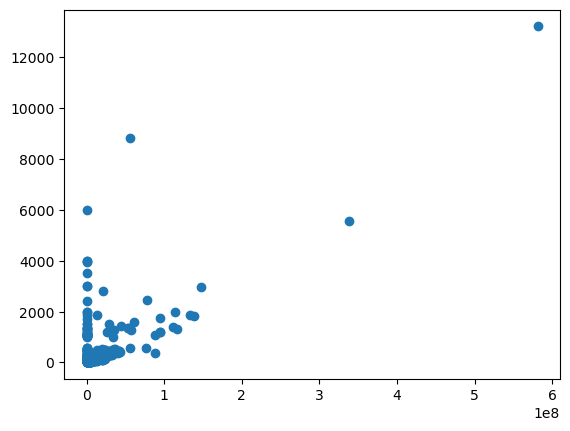

In [ ]:
import matplotlib.pyplot as plt 
df_filtered=df.loc[df['area'] < 100000] 
plt.scatter(df_filtered['price'],df_filtered['area'])